# Image caption generator on Colab

The goal here is to train a model that can be used to generate caption for a given image. A model that combines the power of CNN for image feature extraction and RNN for text generation will be implemented. We can break the implementation down to these steps:
1. Data prep:
X: image features obtained using InceptionV3: (2048,)
y: target caption 

2. Model Definition
3. Model Training

## Data Prep
Generate the inputs (X,y) as per the model requirements and store for later use. For the sake of prototyping, we will later load the inupts and fit the model instead of using generators. The X input must be feature vectors of the image obatined by passing through a CNN. The Y input will be the caption targets prepared as a sequence.

## Generating X:
Image features are extracted from each image in the dataset using InceptionV3 trained on Imagenet. Images are stored locally and the cell below is run to extract features. The output 'data.pkl' is copied to google drive for caption generator training using Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# I run this once locally and copy the generated data.pkl file to my google drive
from os import listdir, path
from pickle import dump
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model  

# I freeze all layers, but you can train the last few layers for your dataset to imporve model performance
def generate_features(img_path):
    # Get the InceptionV3 model trained on imagenet data
    model = InceptionV3(weights='imagenet')
    # Remove the last layer (output softmax layer) from the inception v3
    model= Model(model.input, model.layers[-2].output)
    model.summary()
    # dict to hold final features
    features = dict()
    for name in listdir(img_path):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        img = load_img(path.join(img_path,name), target_size=(299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis=0)
        # preprocess images using preprocess_input() from inception module
        x = preprocess_input(x)
        #print(x.shape)
        feature = model.predict(x, verbose=0)
        #print(feature.shape)
        # reshape from (1, 2048) to (2048, )
        feature = np.reshape(feature, feature.shape[1])
        # store in dict
        image_id = name.split('.')[0]
        features[image_id]=feature
    return features
'''
X = generate_features('flickr30k_images/flickr30k_images/flickr30k_images')     

import pickle
with open('data.pkl', 'wb') as fp:
    pickle.dump(X, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\nX = generate_features('flickr30k_images/flickr30k_images/flickr30k_images')     \n\nimport pickle\nwith open('data.pkl', 'wb') as fp:\n    pickle.dump(X, fp, protocol=pickle.HIGHEST_PROTOCOL)\n"

## Processing Captions:

Let's now prepare the target data. In this section we will deal with reading the captions, eda, pre-processing and then generating the captions in sequences as required by the model.

Pre-Processing: We are interested only in the words to construct the captions. Meaning, we could remove any punctuation or special characters. Also lower-casing of the alphabets and excluding those words with numbers are within the scope of this cleaning.

In [0]:
'''The result.csv file provided has a missing delimiter at pandas index=20001. 
As a correction, just copy the comment from previous index which also belongs to the same image.'''
# read the ground truth: 5 captions per image (31783 * 5)

import pandas as pd
import string
from collections import Counter
import matplotlib.pyplot as plt

#path to the ground truth csv file
def read_csv_pd(filename):
    doc = pd.read_csv(filename,delimiter = '|')
    doc.columns = ['image_name', 'comment_number', 'comment']
    idx=doc.comment.index[doc.comment.isnull()]
    doc.comment[idx]=doc.comment[idx-1]
    doc.comment_number[idx]=doc.comment_number[idx-1]
    return doc

#get the image ID's and associated captions in dictionary
def pd2dict(doc):
    cc = dict()
    for i in doc.index:
        image_id= doc.image_name[i]
        image_id=image_id.split('.')[0]
        if image_id not in cc:
            cc[image_id]= list()
        cc[image_id].append(doc.comment[i])
    return cc

#pre-process the dictionary 
def data_cleaning(cc):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in cc.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string with start and end sequence
            desc_list[i] =  'startseq ' + ' '.join(desc) + ' endseq'

#from the above dictonary, extract all the words
def dict2words(c):
    vocab = list()
    for key in c.keys():
        [vocab.extend(d.split()) for d in c[key]]
    return vocab

#frequency of words in the list of words 
def word_count(wc):
    hc= Counter(wc)
    dfword = pd.DataFrame({"word":list(hc.keys()),"count":list(hc.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return dfword

#generates word histograms
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(25,10))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()



Read data and Perform Exploratory Data Analysis

Total Captions:  158915
Total Image IDs:  31783
Total Words:  1990225


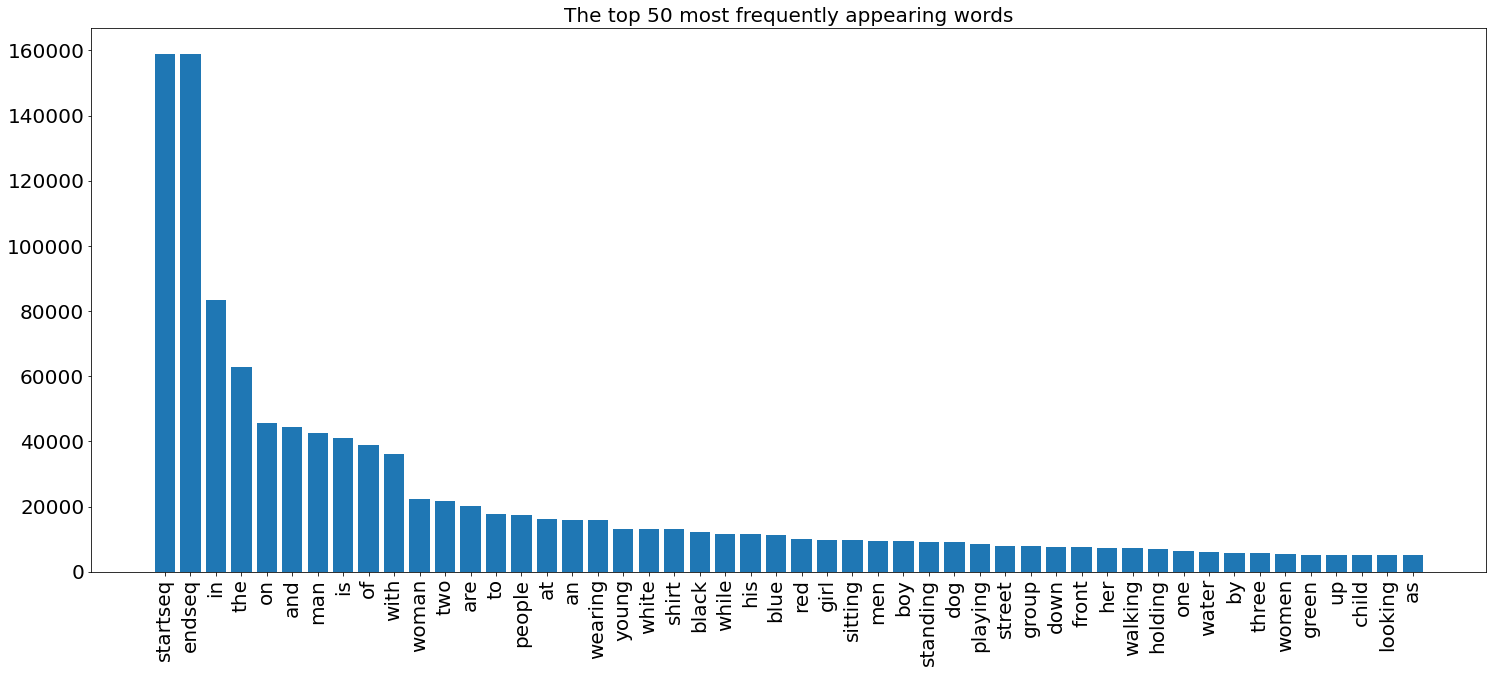

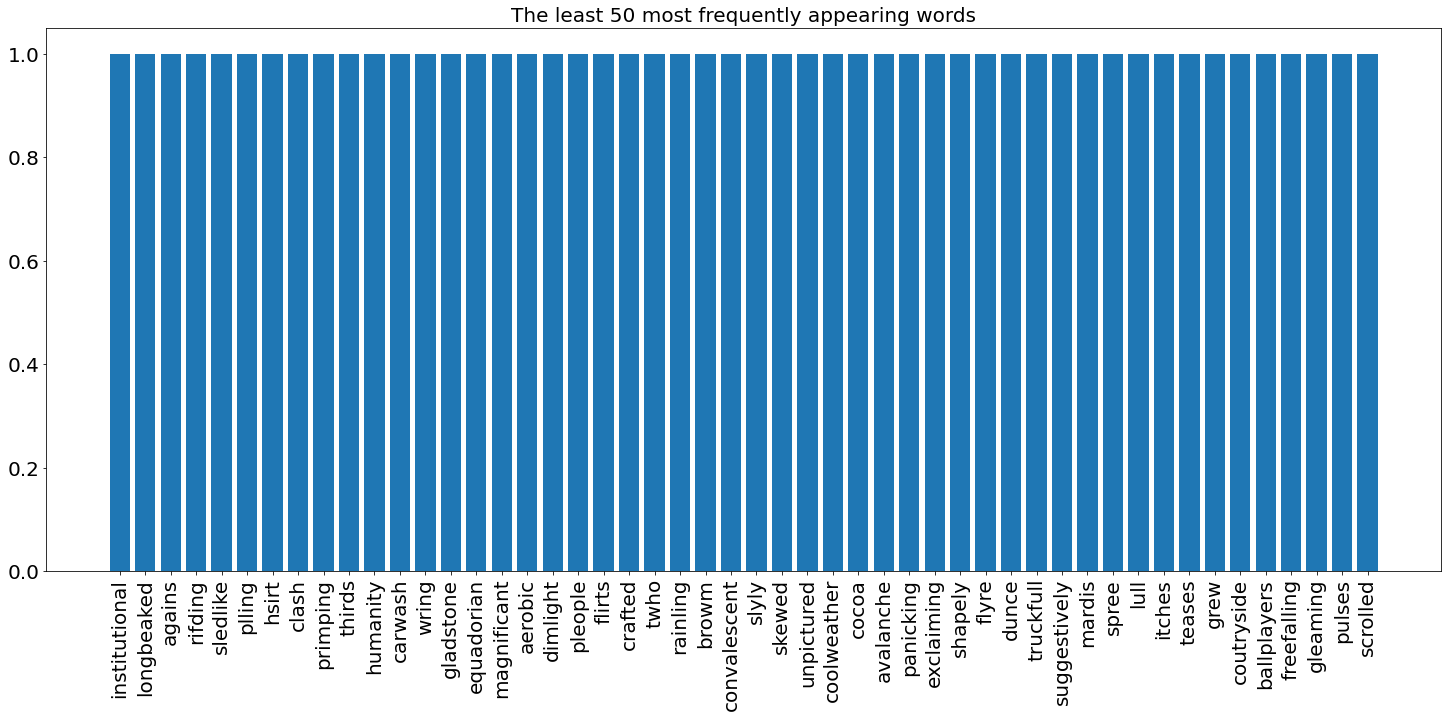

Unique Words:  19737
Words occurring less than 5 time in the dataset:  12073
Words occurring less than 10 time in the dataset:  14300
Words occurring less than 15 time in the dataset:  15379


In [4]:
#read
dir='/content/drive/My Drive/Colab Notebooks/Image_caption_sys'
filename = dir+ r'/results1.csv'
doc = read_csv_pd(filename)
print('Total Captions: ',len(doc))

#get dictionary to hold image ID's with list of captions
cc = pd2dict(doc)
print('Total Image IDs: ',len(cc))
data_cleaning(cc)

#construct a list of words from captions in dictionary
wc = dict2words(cc)
print ('Total Words: ',len(wc))

#plotting to see the words with highest and lowest frequencies
dfword = word_count(wc)
plthist(dfword.iloc[:50,:],title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-50:,:],title="The least 50 most frequently appearing words")

print('Unique Words: ',len(dfword))
#how many words less than 5 time?
print('Words occurring less than 5 time in the dataset: ',len(dfword.index[dfword['count']<5]))

#how many words less than 10 time?
print('Words occurring less than 10 time in the dataset: ',len(dfword.index[dfword['count']<10]))

#how many words less than 15 time?
print('Words occurring less than 15 time in the dataset: ',len(dfword.index[dfword['count']<15]))


Create a list of exclusion words: 
Exclude any word that occurs less that 10 times in the dataset. We will use this while tokenizing.


In [5]:
exclude_id = dfword.index[dfword['count']<10].to_list()
exclude_words= dfword.word.get(exclude_id).to_list()
print ('Size of our vocabulary was: ',len(dfword))
print('Number of words we are excluding: ',len(exclude_id))
print('Size of our new vocabulary: ',len(dfword)-len(exclude_words))

Size of our vocabulary was:  19737
Number of words we are excluding:  14300
Size of our new vocabulary:  5437


## Data Generation Process: 
generator return ([X1,X2],y) for model training

In [0]:
#covert a dictionary of clean descriptions to a list of descriptions for tokenizing and exclude the exclusion list words
#we tokenize only the training set and pickle the tonizer for future use
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from pickle import load, dump

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        for caps in descriptions[key]:
            d = caps.split()
            dn = [n for n in d if n not in exclude_words]
            all_desc.append(' '.join(dn)) 
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def get_max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# data generator, intended to be used in a call to model.fit_generator()
def data_generator(tokenizer, photos, descriptions, max_length,vocab_size, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[str(key)]
            for desc in desc_list:
                # encode the sequence
                #seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0
#returns for every image: 28000 yields

Read the CNN features stored earlier. Create tokenizere and required Params. Set up the data gen.

In [7]:
# read the image features
all_features=load(open(dir + '/data.pkl', 'rb'))
#set batch size
train_batch_sz= 64
val_batch_sz= 64

#train,val,test splits
num_train=28000
num_val=1000
train_descriptions = dict(list(cc.items())[0:num_train])
print('Training set: ',len(train_descriptions))
val_descriptions = dict(list (cc.items())[num_train:num_train+num_val])
print('Validation set: ',len(val_descriptions))

#creat tokenizer one time and dump it
try:
    tokenizer=load(open(dir + '/tokenizer_new.pkl','rb'))
except:
    tokenizer = create_tokenizer(train_descriptions)
    dump(tokenizer, open(dir +'/tokenizer_new.pkl', 'wb'))

#Size of our final vocabulary    
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#max length of a sequnece in dataset (pre-computed once)
max_length = 72 #get_max_length(train_descriptions)
print('Caption Length: %d' % max_length)

train_gen = data_generator(tokenizer,all_features, train_descriptions, max_length, vocab_size,train_batch_sz)
val_gen = data_generator(tokenizer,all_features, val_descriptions, max_length, vocab_size,val_batch_sz)

Training set:  28000
Validation set:  1000
Vocabulary Size: 5438
Caption Length: 72


# Model Definition and Training 

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file=dir+'/model.png', show_shapes=True)
    return model

train_steps= len(train_descriptions)//train_batch_sz
val_steps= len(val_descriptions)//val_batch_sz

model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = dir+'/model_files/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
#model.fit(train_gen,steps_per_epoch=train_steps,epochs=20,validation_data=val_gen,validation_steps= val_steps, verbose=2,callbacks=[checkpoint])
                    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 72, 256)      1392128     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

# Testing

In [0]:
# definitions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import load_model

model_img = InceptionV3(weights='imagenet')
model_img = Model(model_img.input, model_img.layers[-2].output)
vocab_size = 5438
model = define_model(vocab_size, max_length)
#model.load_weights('/content/drive/My Drive/Colab Notebooks/Image_caption_sys/model_files/model-ep009-loss3.128-val_loss3.594.h5')
model.load_weights('D:/Projects/Image_caption_sys_0/model_files/model-ep009-loss3.128-val_loss3.594.h5')

In [0]:
# testing offline
from test_img import test_image_caption
dir = 'D:/Projects/Image_caption_sys_0/flickr30k_images/flickr30k_images/'
images = list()
desc = list()
for f in doc.image_name[28000:28050:5]:
    fn= f'{dir}{f}'
    img=test_image_caption(model_img,model,fn,max_length=72)
    images.append(fn)
    desc.append(img)
for i in range(10):
    img=plt.imread(images[i])
    plt.imshow(img)
    plt.title(' '.join(desc[i]))
    plt.savefig("value" + str(i) + ".png",bbox_inches='tight')